<a href="https://colab.research.google.com/github/Mohit501/Coloring-Gray-images-using-CycleGAN/blob/main/Coloring_Gray_images_with_Cycle_Gan.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

## Importing Required Libraires

In [1]:
!pip install tensorflow-addons

     |████████████████████████████████| 686kB 7.5MB/s 


In [2]:
from __future__ import absolute_import
from __future__ import division
from __future__ import print_function
from tensorflow.keras.layers import Activation, Dense, Input
from tensorflow.keras.layers import Conv2D, Flatten
from tensorflow.keras.layers import Conv2DTranspose
from tensorflow.keras.layers import LeakyReLU
from tensorflow.keras.layers import concatenate
from tensorflow.keras.optimizers import RMSprop
from tensorflow.keras.models import Model
from tensorflow.keras.models import load_model
from tensorflow.keras.datasets import cifar10
from tensorflow_addons.layers import InstanceNormalization
import argparse
import datetime
import numpy as np
import matplotlib.pyplot as plt
import os
import math

## Building a Generator

A generator in cycle gan is a U-Network made up of Encoder and Decoder

1 Encoder Layer

In [3]:
def encoder_layer(inputs,filters=16,kernel_size=3,strides=2,activation='relu',instance_norm=True):
    conv = Conv2D(filters=filters,kernel_size=kernel_size,strides=strides,padding='same')
    x = inputs
    if instance_norm:
        x = InstanceNormalization()(x)
    if activation == 'relu':
        x = Activation('relu')(x)
    else:
        x = LeakyReLU(alpha=0.2)(x)
    x = conv(x)
    return x


2. Decoder Layer

In [4]:
def decoder_layer(inputs,paired_inputs,filters=16,kernel_size=3,strides=2,activation='relu',instance_norm=True):
    conv = Conv2DTranspose(filters=filters,kernel_size=kernel_size,strides=strides,padding='same')
    x = inputs
    if instance_norm:
        x = InstanceNormalization()(x)
    if activation == 'relu':
        x = Activation('relu')(x)
    else:
        x = LeakyReLU(alpha=0.2)(x)
    x = conv(x)
    x = concatenate([x, paired_inputs])
    return x

3. Generator

In [5]:
def build_generator(input_shape,output_shape=None,kernel_size=3,name=None):
    inputs = Input(shape=input_shape)
    channels = int(output_shape[-1])
    e1 = encoder_layer(inputs,32,kernel_size=kernel_size,activation='leaky_relu',strides=1)
    e2 = encoder_layer(e1,64,activation='leaky_relu', kernel_size=kernel_size)
    e3 = encoder_layer(e2,128,activation='leaky_relu', kernel_size=kernel_size)
    e4 = encoder_layer(e3,256,activation='leaky_relu',kernel_size=kernel_size)

    d1 = decoder_layer(e4,e3,128,kernel_size=kernel_size)
    d2 = decoder_layer(d1,e2,64,kernel_size=kernel_size)
    d3 = decoder_layer(d2,e1,32,kernel_size=kernel_size)
    outputs = Conv2DTranspose(channels,kernel_size=kernel_size,strides=1,activation='sigmoid',padding='same')(d3)
    generator = Model(inputs, outputs, name=name)
    return generator


## Discriminator

In [6]:
def build_discriminator(input_shape,kernel_size=3,patchgan=True,name=None):
    inputs = Input(shape=input_shape)
    x = encoder_layer(inputs,32,kernel_size=kernel_size,activation='leaky_relu',instance_norm=False)
    x = encoder_layer(x,64,kernel_size=kernel_size,activation='leaky_relu',instance_norm=False)
    x = encoder_layer(x,128,kernel_size=kernel_size,activation='leaky_relu',instance_norm=False)
    x = encoder_layer(x,256,kernel_size=kernel_size,strides=1,activation='leaky_relu',instance_norm=False)
    # if patchgan=True use nxn-dim output of probability
    # else use 1-dim output of probability
    if patchgan:
        x = LeakyReLU(alpha=0.2)(x)
        outputs = Conv2D(1,kernel_size=kernel_size,strides=2,padding='same')(x)
    else:
        x = Flatten()(x)
        x = Dense(1)(x)
        outputs = Activation('linear')(x)
    discriminator = Model(inputs, outputs, name=name)

    return discriminator

## Building a Train function to train the adversarial network

In [7]:
def train_cyclegan(models,data,params,test_params,test_generator):
    g_source, g_target, d_source, d_target, adv = models
    batch_size, train_steps, patch, model_name = params
    source_data, target_data, test_source_data, test_target_data\
            = data

    titles, dirs = test_params
    save_interval = 500
    target_size = target_data.shape[0]
    source_size = source_data.shape[0]

   
    if patch > 1:
        d_patch = (patch, patch, 1)
        valid = np.ones((batch_size,) + d_patch)
        fake = np.zeros((batch_size,) + d_patch)
    else:
        valid = np.ones([batch_size, 1])
        fake = np.zeros([batch_size, 1])

    valid_fake = np.concatenate((valid, fake))
    start_time = datetime.datetime.now()

    for step in range(train_steps):
        # sample a batch of real target data
        rand_indexes = np.random.randint(0, 
                                         target_size,
                                         size=batch_size)
        real_target = target_data[rand_indexes]

        # sample a batch of real source data
        rand_indexes = np.random.randint(0, 
                                         source_size,
                                         size=batch_size)
        real_source = source_data[rand_indexes]
        # generate a batch of fake target data fr real source data
        fake_target = g_target.predict(real_source)
        
        # combine real and fake into one batch
        x = np.concatenate((real_target, fake_target))
        # train the target discriminator using fake/real data
        metrics = d_target.train_on_batch(x, valid_fake)
        log = "%d: [d_target loss: %f]" % (step, metrics[0])

        # generate a batch of fake source data fr real target data
        fake_source = g_source.predict(real_target)
        x = np.concatenate((real_source, fake_source))
        # train the source discriminator using fake/real data
        metrics = d_source.train_on_batch(x, valid_fake)
        log = "%s [d_source loss: %f]" % (log, metrics[0])

        # train the adversarial network using forward and backward
        # cycles. the generated fake source and target 
        # data attempts to trick the discriminators
        x = [real_source, real_target]
        y = [valid, valid, real_source, real_target]
        metrics = adv.train_on_batch(x, y)
        elapsed_time = datetime.datetime.now() - start_time
        fmt = "%s [adv loss: %f] [time: %s]"
        log = fmt % (log, metrics[0], elapsed_time)
        print(log)
        if (step + 1) % save_interval == 0:
            test_generator((g_source, g_target),
                           (test_source_data, test_target_data),
                           step=step+1,
                           titles=titles,
                           dirs=dirs,
                           show=False)

    # save the models after training the generators
    g_source.save(model_name + "-g_source.h5")
    g_target.save(model_name + "-g_target.h5")



## Building a CycleGAN

In [8]:
def build_cyclegan(shapes,source_name='source',target_name='target',kernel_size=3,patchgan=False,identity=False):
    source_shape, target_shape = shapes
    lr = 2e-4
    decay = 6e-8
    gt_name = "gen_" + target_name
    gs_name = "gen_" + source_name
    dt_name = "dis_" + target_name
    ds_name = "dis_" + source_name
    g_target = build_generator(source_shape,target_shape,kernel_size=kernel_size,name=gt_name)
    g_source = build_generator(target_shape,source_shape,kernel_size=kernel_size,name=gs_name)
    print('---- TARGET GENERATOR ----')
    g_target.summary()
    print('---- SOURCE GENERATOR ----')
    g_source.summary()
    d_target = build_discriminator(target_shape,patchgan=patchgan,kernel_size=kernel_size,name=dt_name)
    d_source = build_discriminator(source_shape,patchgan=patchgan,kernel_size=kernel_size,name=ds_name)
    print('---- TARGET DISCRIMINATOR ----')
    d_target.summary()
    print('---- SOURCE DISCRIMINATOR ----')
    d_source.summary()
    optimizer = RMSprop(lr=lr, decay=decay)
    d_target.compile(loss='mse',
                     optimizer=optimizer,
                     metrics=['accuracy'])
    d_source.compile(loss='mse',
                     optimizer=optimizer,
                     metrics=['accuracy'])

    d_target.trainable = False
    d_source.trainable = False
    source_input = Input(shape=source_shape)
    fake_target = g_target(source_input)
    preal_target = d_target(fake_target)
    reco_source = g_source(fake_target)

    
    target_input = Input(shape=target_shape)
    fake_source = g_source(target_input)
    preal_source = d_source(fake_source)
    reco_target = g_target(fake_source)
    
    if identity:
        iden_source = g_source(source_input)
        iden_target = g_target(target_input)
        loss = ['mse', 'mse', 'mae', 'mae', 'mae', 'mae']
        loss_weights = [1., 1., 10., 10., 0.5, 0.5]
        inputs = [source_input, target_input]
        outputs = [preal_source,preal_target,reco_source,reco_target,iden_source,iden_target]
    else:
        loss = ['mse', 'mse', 'mae', 'mae']
        loss_weights = [1., 1., 10., 10.]
        inputs = [source_input, target_input]
        outputs = [preal_source,preal_target,reco_source,reco_target]

    
    adv = Model(inputs, outputs, name='adversarial')
    optimizer = RMSprop(lr=lr*0.5, decay=decay*0.5)
    adv.compile(loss=loss,loss_weights=loss_weights,optimizer=optimizer,metrics=['accuracy'])
    print('---- ADVERSARIAL NETWORK ----')
    adv.summary()

    return g_source, g_target, d_source, d_target, adv


Function to convert colored cifar images to gray scale

In [9]:
def rgb2gray(rgb):
    return np.dot(rgb[...,:3], [0.299, 0.587, 0.114])

## Function to Display Images

In [10]:
def display_images(imgs,filename,title='',imgs_dir=None,show=True):
    rows = imgs.shape[1]
    cols = imgs.shape[2]
    channels = imgs.shape[3]
    side = int(math.sqrt(imgs.shape[0]))
    assert int(side * side) == imgs.shape[0]

    
    if imgs_dir is None:
        imgs_dir = 'saved_images'
    save_dir = os.path.join(os.getcwd(), imgs_dir)
    if not os.path.isdir(save_dir):
        os.makedirs(save_dir)
    filename = os.path.join(imgs_dir, filename)
    if channels==1:
        imgs = imgs.reshape((side, side, rows, cols))
    else:
        imgs = imgs.reshape((side, side, rows, cols, channels))
    imgs = np.vstack([np.hstack(i) for i in imgs])
    plt.figure()
    plt.axis('off')
    plt.title(title)
    if channels==1:
        plt.imshow(imgs, interpolation='none', cmap='gray')
    else:
        plt.imshow(imgs, interpolation='none')
    plt.savefig(filename)
    if show:
        plt.show()
    
    plt.close('all')

## Building a test generator

In [11]:
def test_generator(generators,test_data,step,titles,dirs,todisplay=100,show=False):
    g_source, g_target = generators
    test_source_data, test_target_data = test_data
    t1, t2, t3, t4 = titles
    title_pred_source = t1
    title_pred_target = t2
    title_reco_source = t3
    title_reco_target = t4
    dir_pred_source, dir_pred_target = dirs

    pred_target_data = g_target.predict(test_source_data)
    pred_source_data = g_source.predict(test_target_data)
    reco_source_data = g_source.predict(pred_target_data)
    reco_target_data = g_target.predict(pred_source_data)

    
    imgs = pred_target_data[:todisplay]
    filename = '%06d.png' % step
    step = " Step: {:,}".format(step)
    title = title_pred_target + step
    display_images(imgs,
                   filename=filename,
                   imgs_dir=dir_pred_target,
                   title=title,
                   show=show)

    imgs = pred_source_data[:todisplay]
    title = title_pred_source
    display_images(imgs,
                   filename=filename,
                   imgs_dir=dir_pred_source,
                   title=title,
                   show=show)

    imgs = reco_source_data[:todisplay]
    title = title_reco_source
    filename = "reconstructed_source.png"
    display_images(imgs,
                   filename=filename,
                   imgs_dir=dir_pred_source,
                   title=title,
                   show=show)

    imgs = reco_target_data[:todisplay]
    title = title_reco_target
    filename = "reconstructed_target.png"
    display_images(imgs,
                   filename=filename,
                   imgs_dir=dir_pred_target,
                   title=title,
                   show=show)

## Function to load data

In [12]:
def load_data():
    
    (target_data, _), (test_target_data, _) = cifar10.load_data()
    todisplay = 100

    
    rows = target_data.shape[1]
    cols = target_data.shape[2]
    channels = target_data.shape[3]

   
    source_data = rgb2gray(target_data)
    test_source_data = rgb2gray(test_target_data)
    
    source_data = source_data.reshape(source_data.shape[0],rows,cols,1)
    test_source_data = test_source_data.reshape(test_source_data.shape[0],rows,cols,1)
    data = (source_data, target_data, test_source_data, test_target_data)
    filenames = ('cifar10_test_source.png', 'cifar10_test_target.png')
    titles = ('CIFAR10 test source images', 'CIFAR10 test target images')
    test_source_filename, test_target_filename = filenames
    test_source_title, test_target_title = titles
    imgs = test_target_data[:todisplay]
    display_images(imgs,filename=test_target_filename,title=test_target_title)
    imgs = test_source_data[:todisplay]
    display_images(imgs,filename=test_source_filename,title=test_source_title)
    target_data = target_data.astype('float32')  / 255
    test_target_data = test_target_data.astype('float32') / 255
    source_data = source_data.astype('float32')  / 255
    test_source_data = test_source_data.astype('float32') / 255
    data = (source_data, target_data, test_source_data, test_target_data)

    rows = source_data.shape[1]
    cols = source_data.shape[2]
    channels = source_data.shape[3]
    source_shape = (rows, cols, channels)

    rows = target_data.shape[1]
    cols = target_data.shape[2]
    channels = target_data.shape[3]
    target_shape = (rows, cols, channels)

    shapes = (source_shape, target_shape)
    
    return data, shapes



## Building and training cyclegan

In [13]:
def graycifar10_cross_colorcifar10(g_models=None):
    model_name = 'cyclegan_cifar10'
    batch_size = 32
    train_steps = 10000
    patchgan = True
    kernel_size = 3
    postfix = ('%dp' % kernel_size) if patchgan else ('%d' % kernel_size)

    data, shapes = load_data()
    source_data, _, test_source_data, test_target_data = data
    titles = ('CIFAR10 predicted source images.',
              'CIFAR10 predicted target images.',
              'CIFAR10 reconstructed source images.',
              'CIFAR10 reconstructed target images.')
    dirs = ('cifar10_source-%s' % postfix, \
            'cifar10_target-%s' % postfix)
    if g_models is not None:
        g_source, g_target = g_models
        test_generator((g_source, g_target),(test_source_data,test_target_data),step=0,titles=titles,dirs=dirs,show=True)
        return
    models = build_cyclegan(shapes,"gray-%s" % postfix,"color-%s" % postfix,kernel_size=kernel_size,patchgan=patchgan)
    patch = int(source_data.shape[1] / 2**4) if patchgan else 1
    params = (batch_size, train_steps, patch, model_name)
    test_params = (titles, dirs)
    train_cyclegan(models,data,params,test_params,test_generator)


170500096/170498071 [==============================] - 4s 0us/step


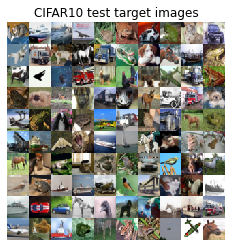

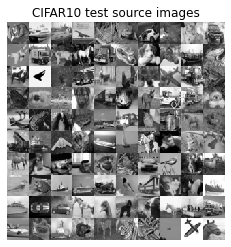

Streaming output truncated to the last 5000 lines.
5000: [d_target loss: 0.175640] [d_source loss: 0.202781] [adv loss: 2.563591] [time: 0:12:23.104641]
5001: [d_target loss: 0.163790] [d_source loss: 0.212601] [adv loss: 2.759742] [time: 0:12:23.229524]
5002: [d_target loss: 0.135032] [d_source loss: 0.190956] [adv loss: 2.528416] [time: 0:12:23.365691]
5003: [d_target loss: 0.186430] [d_source loss: 0.212826] [adv loss: 2.495109] [time: 0:12:23.496274]
5004: [d_target loss: 0.177307] [d_source loss: 0.231847] [adv loss: 2.583911] [time: 0:12:23.639514]
5005: [d_target loss: 0.150304] [d_source loss: 0.220826] [adv loss: 2.704431] [time: 0:12:23.763957]
5006: [d_target loss: 0.180970] [d_source loss: 0.192519] [adv loss: 2.493502] [time: 0:12:23.887726]
5007: [d_target loss: 0.149863] [d_source loss: 0.189795] [adv loss: 2.711257] [time: 0:12:24.017809]
5008: [d_target loss: 0.145162] [d_source loss: 0.181812] [adv loss: 2.572587] [time: 0:12:24.157009]
5009: [d_target loss: 0.193859]

In [14]:
graycifar10_cross_colorcifar10()

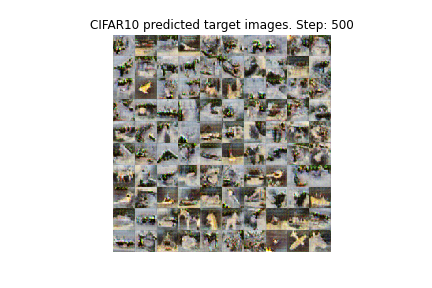

In [22]:
from PIL import Image
Image.open('/content/cifar10_target-3p/000500.png')

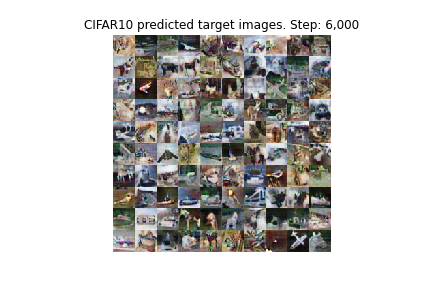

In [25]:
Image.open('/content/cifar10_target-3p/006000.png')

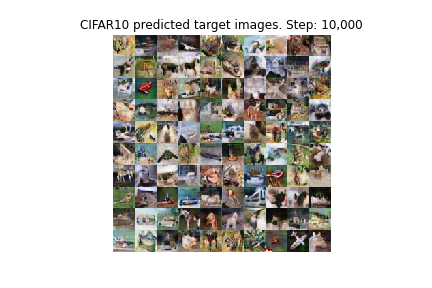

In [26]:
Image.open('/content/cifar10_target-3p/010000.png')